<a href="https://colab.research.google.com/github/rohitrav02/RohitRavindran_Spider_ML_Task1/blob/main/RL_try3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.1 MB/s eta 0:00:00


In [2]:
!pip install stable_baselines3 gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 16.2 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2398825 sha256=be9ec11e3887eb6a7e4ba40fa4ccad5ac7d1b40af0d7e4a59d046d441187b0af
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [3]:
import gymnasium as gym
env = gym.make("CarRacing-v3")
obs, info = env.reset(seed=42)
print("Observation shape:", obs.shape)
print("Action space:", env.action_space)

env.close()


Observation shape: (96, 96, 3)
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)


In [4]:
import numpy as np

DISCRETE_ACTIONS = {
    0: np.array([-1.0, 1.0, 0.0]),  # left + gas
    1: np.array([0.0, 1.0, 0.0]),   # straight + gas
    2: np.array([1.0, 1.0, 0.0]),   # right + gas
    3: np.array([0.0, 0.0, 0.0]),   # coast
    4: np.array([0.0, 0.0, 0.8])    # brake
}

print("Discrete actions:", len(DISCRETE_ACTIONS))


Discrete actions: 5


In [7]:
import random

class QLearningAgent:
    """
    Classical tabular Q-learning agent with aggressive state compression.
    Designed to demonstrate failure on high-dimensional pixel inputs.
    """
    def __init__(
        self,
        n_actions,
        lr=0.1,
        gamma=0.99,
        eps_start=1.0,
        eps_end=0.1,
        eps_decay=0.995
    ):
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

        # dictionary-based Q-table
        self.Q = {}

    def _state_key(self, state):
        """
        Compress the state aggressively.
        This is necessary because a full pixel Q-table is infeasible.
        """
        return tuple(state.flatten()[:50])

    def act(self, state):
        key = self._state_key(state)

        if random.random() < self.eps or key not in self.Q:
            return random.randint(0, self.n_actions - 1)

        return np.argmax(self.Q[key])

    def update(self, state, action, reward, next_state):
        k1 = self._state_key(state)
        k2 = self._state_key(next_state)

        if k1 not in self.Q:
            self.Q[k1] = np.zeros(self.n_actions)
        if k2 not in self.Q:
            self.Q[k2] = np.zeros(self.n_actions)

        td_target = reward + self.gamma * np.max(self.Q[k2])
        td_error = td_target - self.Q[k1][action]
        self.Q[k1][action] += self.lr * td_error

    def decay_epsilon(self):
        self.eps = max(self.eps_end, self.eps * self.eps_decay)


In [9]:
import cv2
import numpy as np
from collections import deque

class Preprocessor:
    """
    Converts raw RGB frames into stacked grayscale frames.
    This is the standard preprocessing pipeline used in pixel-based RL.
    """
    def __init__(self, stack_size=4):
        self.stack = deque(maxlen=stack_size)

    def process(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (84, 84))
        normalized = resized / 255.0
        return normalized

    def reset(self, frame):
        processed = self.process(frame)
        self.stack.clear()
        for _ in range(4):
            self.stack.append(processed)
        return np.stack(self.stack, axis=0)

    def step(self, frame):
        processed = self.process(frame)
        self.stack.append(processed)
        return np.stack(self.stack, axis=0)


In [10]:
import gymnasium as gym

env = gym.make("CarRacing-v3", render_mode="rgb_array")
prep = Preprocessor()
agent = QLearningAgent(n_actions=len(DISCRETE_ACTIONS))

num_episodes = 50
episode_rewards = []

for ep in range(num_episodes):
    obs, _ = env.reset(seed=ep)
    frame = env.render()
    state = prep.reset(frame)

    total_reward = 0

    for t in range(500):
        action_id = agent.act(state)
        action = DISCRETE_ACTIONS[action_id]

        obs, reward, terminated, truncated, _ = env.step(action)
        frame = env.render()
        next_state = prep.step(frame)

        agent.update(state, action_id, reward, next_state)

        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    agent.decay_epsilon()
    episode_rewards.append(total_reward)

    print(
        f"Episode {ep+1:03d} | "
        f"Reward: {total_reward:7.1f} | "
        f"Epsilon: {agent.eps:.3f}"
    )

env.close()


Episode 001 | Reward:     6.4 | Epsilon: 0.995
Episode 002 | Reward:    26.4 | Epsilon: 0.990
Episode 003 | Reward:     9.7 | Epsilon: 0.985
Episode 004 | Reward:    23.8 | Epsilon: 0.980
Episode 005 | Reward:    19.1 | Epsilon: 0.975
Episode 006 | Reward:    13.8 | Epsilon: 0.970
Episode 007 | Reward:    13.4 | Epsilon: 0.966
Episode 008 | Reward:    15.8 | Epsilon: 0.961
Episode 009 | Reward:    57.6 | Epsilon: 0.956
Episode 010 | Reward:     9.6 | Epsilon: 0.951
Episode 011 | Reward:    23.1 | Epsilon: 0.946
Episode 012 | Reward:    50.4 | Epsilon: 0.942
Episode 013 | Reward:    25.9 | Epsilon: 0.937
Episode 014 | Reward:    28.3 | Epsilon: 0.932
Episode 015 | Reward:    21.2 | Epsilon: 0.928
Episode 016 | Reward:    22.1 | Epsilon: 0.923
Episode 017 | Reward:    25.6 | Epsilon: 0.918
Episode 018 | Reward:    19.8 | Epsilon: 0.914
Episode 019 | Reward:    13.9 | Epsilon: 0.909
Episode 020 | Reward:    15.7 | Epsilon: 0.905
Episode 021 | Reward:    14.1 | Epsilon: 0.900
Episode 022 |

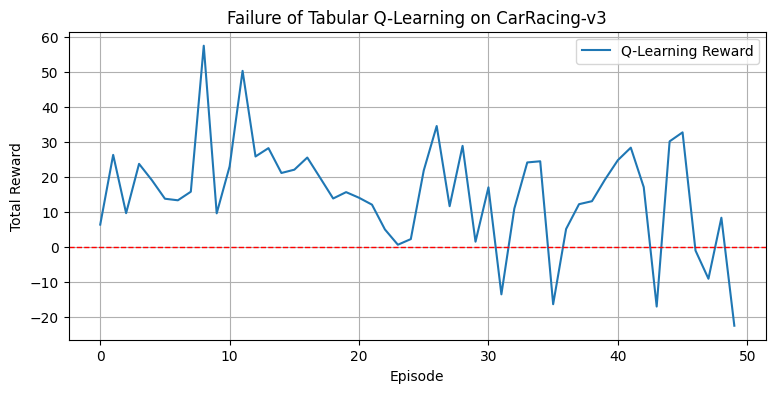

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.plot(episode_rewards, label="Q-Learning Reward")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Failure of Tabular Q-Learning on CarRacing-v3")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEncoder(nn.Module):
    """
    CNN feature extractor for pixel-based RL.
    Follows the canonical Atari DQN architecture.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x.view(x.size(0), -1)


In [13]:
class DQN(nn.Module):
    """
    Deep Q-Network mapping pixel observations to Q-values.
    """
    def __init__(self, n_actions):
        super().__init__()
        self.encoder = CNNEncoder()
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [14]:
from collections import deque
import random

class ReplayBuffer:
    """
    Experience replay buffer for off-policy DQN.
    """
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQN(n_actions=len(DISCRETE_ACTIONS)).to(device)
target_net = DQN(n_actions=len(DISCRETE_ACTIONS)).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer()


In [16]:
def train_dqn_step(batch_size=32, gamma=0.99):
    if len(replay_buffer) < batch_size:
        return None

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        target = rewards + gamma * next_q * (1 - dones)

    loss = F.mse_loss(q_values, target)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()

    return loss.item()


In [17]:
import gymnasium as gym
import numpy as np
from collections import deque

env = gym.make("CarRacing-v3", render_mode="rgb_array")
prep = Preprocessor()

num_episodes = 20
max_steps = 500
batch_size = 32
target_update_freq = 5

episode_rewards = []
losses = []

epsilon = 1.0
eps_min = 0.1
eps_decay = 0.995

for ep in range(num_episodes):
    obs, _ = env.reset(seed=ep)
    frame = env.render()
    state = prep.reset(frame)

    total_reward = 0

    for t in range(max_steps):
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action_id = np.random.randint(len(DISCRETE_ACTIONS))
        else:
            with torch.no_grad():
                s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_vals = policy_net(s)
                action_id = torch.argmax(q_vals).item()

        action = DISCRETE_ACTIONS[action_id]

        obs, reward, terminated, truncated, _ = env.step(action)
        frame = env.render()
        next_state = prep.step(frame)

        done = terminated or truncated
        replay_buffer.push(state, action_id, reward, next_state, done)

        loss = train_dqn_step(batch_size=batch_size)
        if loss is not None:
            losses.append(loss)

        state = next_state
        total_reward += reward

        if done:
            break

    epsilon = max(eps_min, epsilon * eps_decay)
    episode_rewards.append(total_reward)

    # Update target network
    if ep % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(
        f"[DQN] Episode {ep+1:02d} | "
        f"Reward: {total_reward:7.1f} | "
        f"Epsilon: {epsilon:.3f}"
    )

env.close()


/tmp/ipython-input-1035135420.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  torch.tensor(states, dtype=torch.float32),


[DQN] Episode 01 | Reward:    -3.0 | Epsilon: 0.995
[DQN] Episode 02 | Reward:    26.4 | Epsilon: 0.990
[DQN] Episode 03 | Reward:     9.7 | Epsilon: 0.985
[DQN] Episode 04 | Reward:    20.1 | Epsilon: 0.980
[DQN] Episode 05 | Reward:    26.4 | Epsilon: 0.975
[DQN] Episode 06 | Reward:    10.8 | Epsilon: 0.970
[DQN] Episode 07 | Reward:    23.9 | Epsilon: 0.966
[DQN] Episode 08 | Reward:     0.2 | Epsilon: 0.961
[DQN] Episode 09 | Reward:    49.6 | Epsilon: 0.956
[DQN] Episode 10 | Reward:    27.2 | Epsilon: 0.951
[DQN] Episode 11 | Reward:    19.8 | Epsilon: 0.946
[DQN] Episode 12 | Reward:    23.4 | Epsilon: 0.942
[DQN] Episode 13 | Reward:    16.0 | Epsilon: 0.937
[DQN] Episode 14 | Reward:    24.7 | Epsilon: 0.932
[DQN] Episode 15 | Reward:    14.4 | Epsilon: 0.928
[DQN] Episode 16 | Reward:    15.6 | Epsilon: 0.923
[DQN] Episode 17 | Reward:    42.8 | Epsilon: 0.918
[DQN] Episode 18 | Reward:    13.1 | Epsilon: 0.914
[DQN] Episode 19 | Reward:    20.3 | Epsilon: 0.909
[DQN] Episod

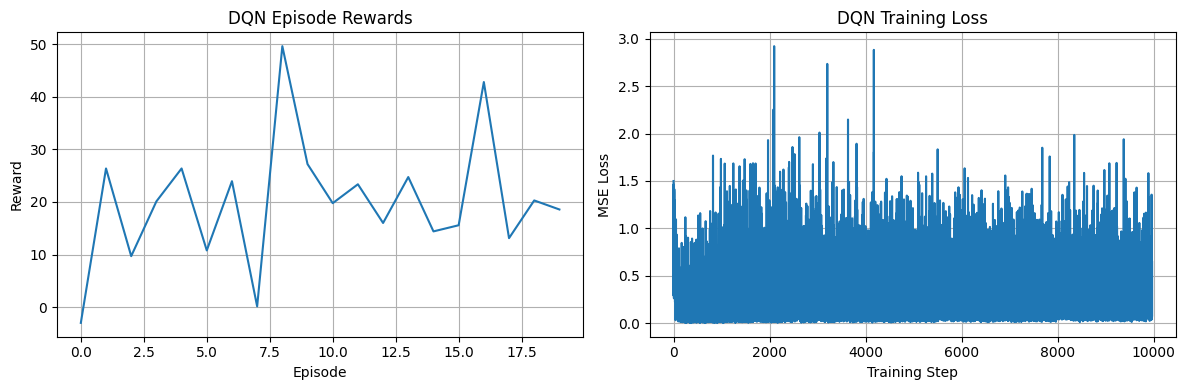

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("DQN Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("DQN Training Loss")
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEncoder(nn.Module):
    """
    Shared CNN encoder for Actor and Critic.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x.view(x.size(0), -1)


In [32]:

from torch.distributions import Normal

def select_action(model, state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    mu, std, value = model(state)

    dist = Normal(mu, std)
    raw_action = dist.rsample()  # reparameterization trick
    action = torch.tanh(raw_action)

    log_prob = dist.log_prob(raw_action).sum(dim=1)
    log_prob -= torch.log(1 - action.pow(2) + 1e-7).sum(dim=1)  # tanh correction
    return action.squeeze(0).detach().cpu().numpy(), log_prob.item(), value.item()




In [21]:
class RolloutBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def clear(self):
        self.__init__()


In [22]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0
    values = values + [0]

    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)

    return advantages


In [30]:
def ppo_update(model, optimizer, buffer, epochs=4, batch_size=64,
               clip_eps=0.2, gamma=0.99, lam=0.95):

    states = torch.tensor(buffer.states, dtype=torch.float32).to(device)
    actions = torch.tensor(buffer.actions, dtype=torch.float32).to(device)
    old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
    rewards = buffer.rewards
    dones = buffer.dones
    values = buffer.values

    advantages = compute_gae(rewards, values, dones, gamma, lam)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    returns = advantages + torch.tensor(values, dtype=torch.float32).to(device)

    N = len(states)
    idxs = np.arange(N)

    for _ in range(epochs):
        np.random.shuffle(idxs)

        for start in range(0, N, batch_size):
            batch = idxs[start:start+batch_size]

            mu, std, new_values = model(states[batch])
            dist = Normal(mu, std)

            new_log_probs = dist.log_prob(actions[batch]).sum(dim=1)
            ratio = torch.exp(new_log_probs - old_log_probs[batch])

            clipped_ratio = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps)
            policy_loss = -torch.min(
                ratio * advantages[batch],
                clipped_ratio * advantages[batch]
            ).mean()

            value_loss = F.mse_loss(new_values.squeeze(), returns[batch])
            entropy = dist.entropy().sum(dim=1).mean()

            loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorCritic(nn.Module):
    """
    Actor-Critic network for PPO with continuous actions.
    """
    def __init__(self, action_dim):
        super().__init__()
        self.encoder = CNNEncoder()

        self.fc = nn.Linear(3136, 512)

        # Actor head
        self.mu = nn.Linear(512, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

        # Critic head
        self.value = nn.Linear(512, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc(x))

        mu = self.mu(x)
        std = torch.exp(self.log_std)

        value = self.value(x)
        return mu, std, value


In [34]:
import gymnasium as gym

env = gym.make("CarRacing-v3", render_mode="rgb_array")
prep = Preprocessor()

model = ActorCritic(action_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

buffer = RolloutBuffer()

num_episodes = 40
max_steps = 500

for ep in range(num_episodes):
    obs, _ = env.reset(seed=ep)
    frame = env.render()
    state = prep.reset(frame)

    ep_reward = 0

    for t in range(max_steps):
        action, log_prob, value = select_action(model, state)

        obs, reward, terminated, truncated, _ = env.step(action)
        frame = env.render()
        next_state = prep.step(frame)

        buffer.states.append(state)
        buffer.actions.append(action)
        buffer.log_probs.append(log_prob)
        buffer.rewards.append(reward)
        buffer.dones.append(terminated or truncated)
        buffer.values.append(value)

        state = next_state
        ep_reward += reward

        if terminated or truncated:
            break

    loss = ppo_update(model, optimizer, buffer)
    buffer.clear()
    print(f"[PPO] Episode {ep+1:02d} | Reward: {ep_reward:.1f}")


env.close()


[PPO] Episode 01 | Reward: -24.9
[PPO] Episode 02 | Reward: -20.9
[PPO] Episode 03 | Reward: -17.2
[PPO] Episode 04 | Reward: -20.5
[PPO] Episode 05 | Reward: -10.0
[PPO] Episode 06 | Reward: -10.5
[PPO] Episode 07 | Reward: -11.3
[PPO] Episode 08 | Reward: -15.5
[PPO] Episode 09 | Reward: -14.1
[PPO] Episode 10 | Reward: -21.9
[PPO] Episode 11 | Reward: -16.8
[PPO] Episode 12 | Reward: -7.5
[PPO] Episode 13 | Reward: -17.0
[PPO] Episode 14 | Reward: -18.0
[PPO] Episode 15 | Reward: -26.3
[PPO] Episode 16 | Reward: -23.8
[PPO] Episode 17 | Reward: -12.2
[PPO] Episode 18 | Reward: -16.8
[PPO] Episode 19 | Reward: -18.1
[PPO] Episode 20 | Reward: -27.1
[PPO] Episode 21 | Reward: -27.6
[PPO] Episode 22 | Reward: -23.4
[PPO] Episode 23 | Reward: -16.4
[PPO] Episode 24 | Reward: -12.8
[PPO] Episode 25 | Reward: -17.3
[PPO] Episode 26 | Reward: -14.1
[PPO] Episode 27 | Reward: -15.4
[PPO] Episode 28 | Reward: -11.0
[PPO] Episode 29 | Reward: -17.1
[PPO] Episode 30 | Reward: -19.1
[PPO] Episo

In [35]:
import torch

torch.save(model.state_dict(), "ppo_from_scratch_carracing.pt")


In [36]:
def evaluate_ppo(model, env, episodes=20, seed=123):
    rewards = []

    for ep in range(episodes):
        obs, _ = env.reset(seed=seed + ep)
        frame = env.render()
        state = prep.reset(frame)

        total_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                action, _, _ = select_action(model, state)

            obs, reward, terminated, truncated, _ = env.step(action)
            frame = env.render()
            state = prep.step(frame)

            total_reward += reward
            done = terminated or truncated

        rewards.append(total_reward)

    return rewards


In [37]:
eval_env = gym.make("CarRacing-v3", render_mode="rgb_array")
ppo_eval_rewards = evaluate_ppo(model, eval_env, episodes=20)
eval_env.close()

print("PPO Evaluation Mean:", sum(ppo_eval_rewards) / len(ppo_eval_rewards))
print("PPO Evaluation Std:", np.std(ppo_eval_rewards))


PPO Evaluation Mean: -53.49661363513859
PPO Evaluation Std: 4.976790250631557
